In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error


import os
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# 1 Non-linear regression

In [2]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## 1.1 Data acquisition

We keep the Dataset wrapper from Ex. 02.

In [3]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y ).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index], self.y[index]
  
  def __len__(self) -> int:
    return self.len

In Exercise 02, we manually split our data into training and test set. Since this is a standard procedure, it is helpful to write a function doing that for us. Feel free to modify it!

In [4]:
def split_data(x_full: np.ndarray,
               y_full: np.ndarray,
               train_fraction: float):
    """Generates three pytorch Datasets (full, train, test) given a set of features and labels."""

    # define fraction of data used for training
    assert x_full.shape[0] == y_full.shape[0]
    
    n_samples = y_full.shape[0]

    n_train = int(train_fraction * n_samples)

    # get indices for training and test set
    ids = np.arange(n_samples)
    np.random.shuffle(ids)
    ids_train, ids_test  = np.split(ids, [n_train])

    all_data = Data(x_full, y_full)
    train_data = Data(x_full[ids_train], y_full[ids_train])
    test_data = Data(x_full[ids_test], y_full[ids_test])

    return all_data, train_data, test_data

## 1.2 Neural network

In [5]:
class MLP(nn.Module):
    def __init__(self, n_units: list, activation= nn.ReLU()):
        """
            Simple multi-layer perceptron (MLP).

            Parameters:
            -----------
            n_units : List of integers specifying the dimensions of input and output and the hidden layers.
            activation: Activation function used for non-linearity. 


            Example:
            -----------

            dim_hidden = 100
            dim_in = 2
            dim_out = 5

            # MLP with input dimension 2, output dimension 5, and 4 hidden layers of dimension 100
            model = MLP([dim_in,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_out],activation=nn.ReLU()).to(DEVICE)

        """
        super().__init__()

        # Get input and output dimensions
        dims_in = n_units[:-1]
        dims_out = n_units[1:]

        layers = []

        # Add linear layers (and activation function after all layers except the final one)
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            layers.append(torch.nn.Linear(dim_in, dim_out))
            
            if i < len(n_units) - 2:
                layers.append(activation)
        

        self._layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
            MLP forward pass

        """
        return self._layers(x)
    
    def count_parameters(self): 
        """
            Counts the number of trainable parameters.

        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In Exercise 02, we saw how a basic training loop in pytorch looks like. Since we will need this exact training procedure a number of times, it is useful to define a function for it. Feel free to modify it!

In [6]:
def train(model:nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.modules.loss._Loss):
    """
        Basic training loop for a pytorch model.

        Parameters:
        -----------
        model : pytorch model.
        train_loader : pytorch Dataloader containing the training data.
        optimizer: Optimizer for gradient descent. 
        criterion: Loss function. 
        

        Example usage:
        -----------

        model = (...) # a pytorch model
        criterion = (...) # a pytorch loss
        optimizer = (...) # a pytorch optimizer
        trainloader = (...) # a pytorch DataLoader containing the training data

        n_epochs = 10000
        for epoch in range(1, n_epochs):
            epoch_loss = train(model, trainloader,optimizer, criterion)
            

    """
        
    # Set model to training mode
    model.train()
    epoch_loss = 0
    n_batches = len(train_loader)

    # Loop over each batch from the training set
    for (data, target) in train_loader:
    
        # Copy data to GPU if needed
        data = data.to(DEVICE)
        target = target.to(DEVICE)

        # set optimizer to zero grad to remove previous gradients
        optimizer.zero_grad() 

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # get gradients
        loss.backward()
        
        # gradient descent
        optimizer.step()
        
        epoch_loss += loss.data.item()

    return epoch_loss / n_batches

# 2 Solution

## 2.1 Data Acquisition

In [7]:
def f(x: float):
    return x + 1.5*np.power(x, 2) + 0.5*np.power(x, 3) - 0.7*np.power(x,4) + np.sin(5*x) + np.cos(10*x)

In [8]:
x = np.linspace(-1, 2, 100).reshape(-1,1)
y = f(x)
all_data, train_data, test_data = split_data(x, y, 0.75)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

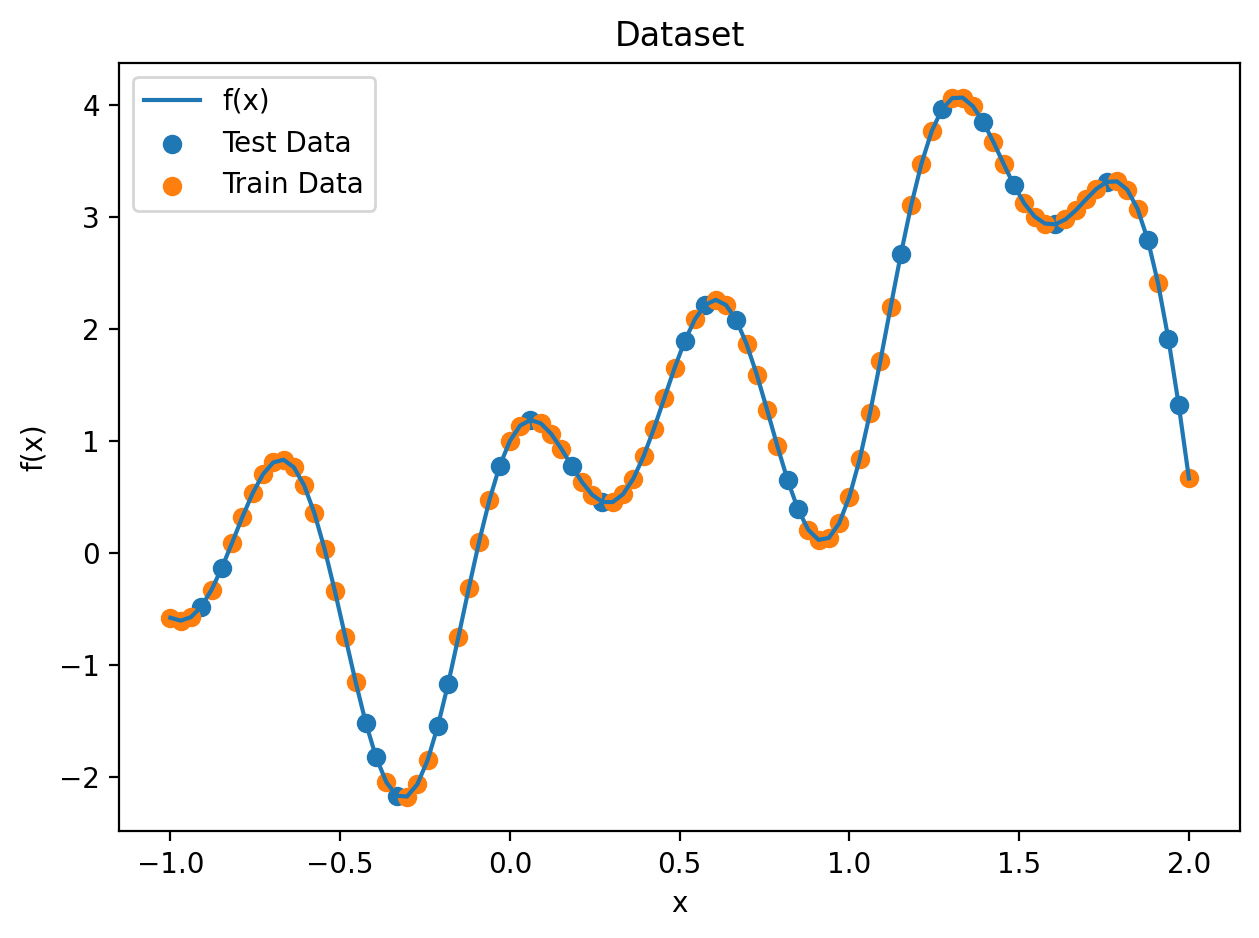

In [9]:
plt.plot(x, y, label="f(x)")
plt.scatter(test_data.x, test_data.y, label="Test Data")
plt.scatter(train_data.x, train_data.y, label="Train Data")

plt.title("Dataset")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.tight_layout()
plt.savefig("data_plot.png", dpi=600)
plt.show()

## 2.2 Training Models

In [10]:
def save_models(models):
    for (i, model) in enumerate(models):
        torch.save(model, f"models/model_{i}.pt")
    print("Finished saving!")

def load_models(dir_path):
    no_models = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
    models = [0] * no_models
    for i in range(no_models):
        model = torch.load(f"{dir_path}/model_{i}.pt", weights_only=False)
        model.eval()
        models[i] = model
    return models

In [11]:
# no_models = 100
# nepochs = 1000

# models = [0] * no_models
# loses= np.zeros((no_models, nepochs))

# for i in range(no_models):
#     # generate random integer for depth of network
#     depth  = np.random.randint(1, 10)

#     # generate random integer for number of nodes in hidden layer
#     number_of_nodes = np.random.randint(1, 100)

    
#     nunits = np.ones(depth+2, dtype=np.int64)
#     nunits[1:-1] = number_of_nodes
#     model = MLP(nunits)
#     optimizer = torch.optim.Adam(model.parameters())
#     loss = nn.MSELoss()
#     for epoch in range(nepochs):
#         loses[i, epoch] = train(model, train_loader, optimizer, loss)
#     models[i] = model
# save_models(models)

In [12]:
models = load_models("models")

## 2.3 Evaluating Models

In [13]:
number_of_parameters = [0] * len(models)
mse_test_error = [0] * len(models)
mse_train_error = [0] * len(models)
sum_of_errors = [0] * len(models)

for (i, model) in enumerate(models):
    with torch.no_grad():
        train_pred = model(train_data.x)
        test_pred = model(test_data.x)

    mse_test = mean_squared_error(test_data.y,test_pred)
    mse_train = mean_squared_error(train_data.y,train_pred)

    number_of_parameters[i] = model.count_parameters()
    mse_test_error[i] = mse_test
    mse_train_error[i] = mse_train
    sum_of_errors[i] = mse_test + mse_train

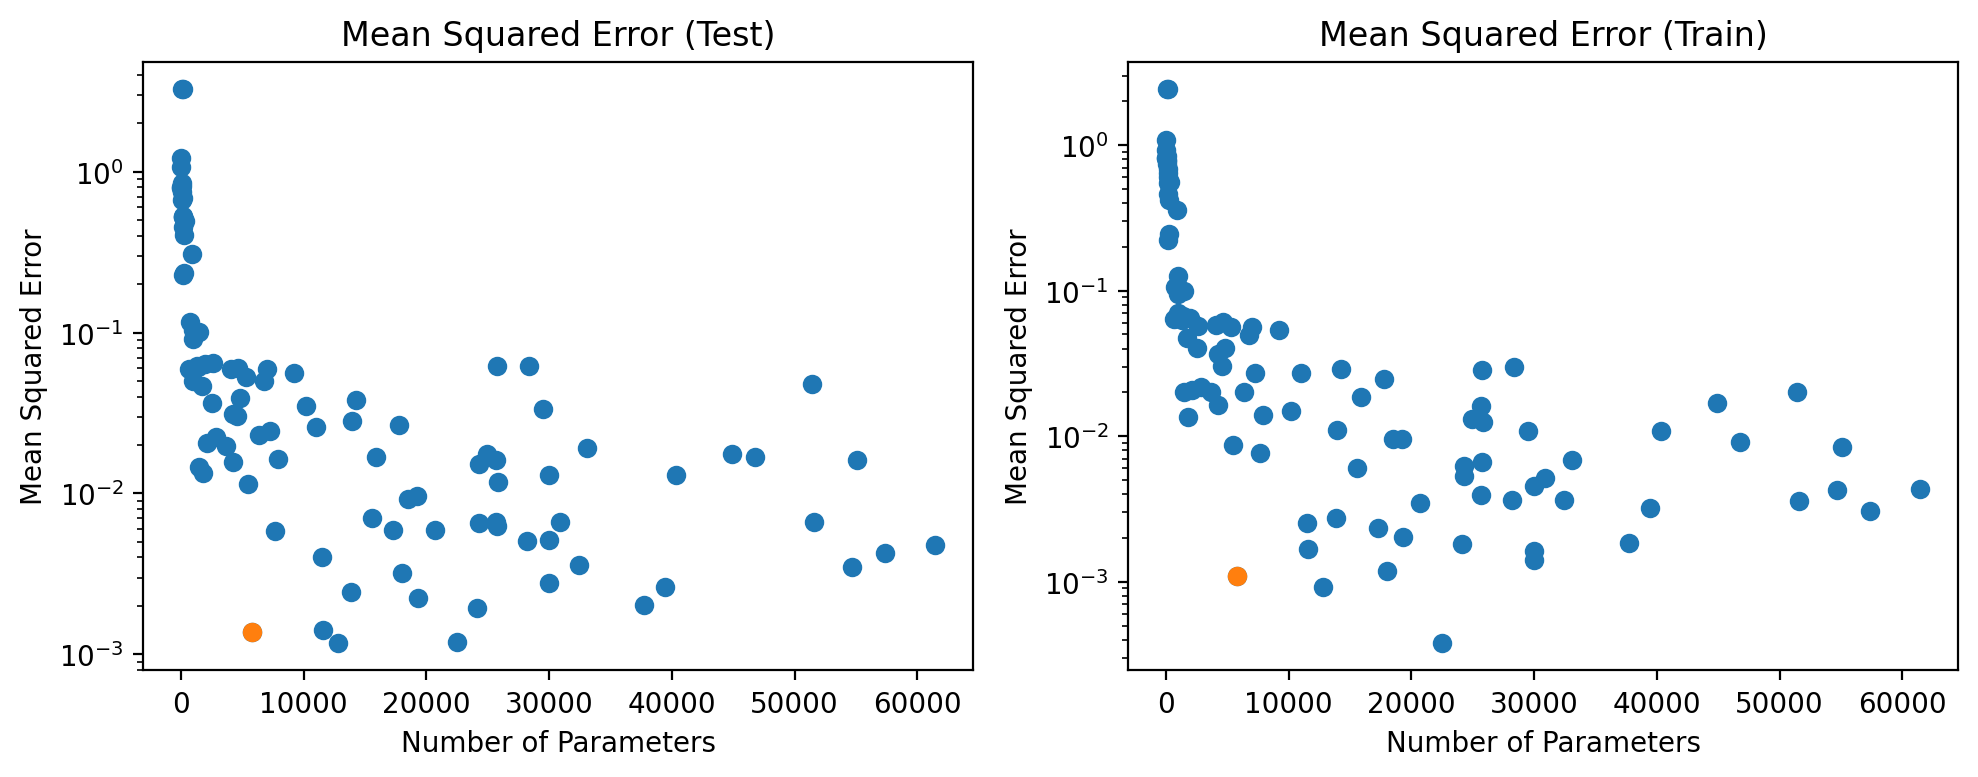

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Mean Squared Error (Test)")
i = 36
plt.scatter(number_of_parameters, mse_test_error)
plt.scatter(number_of_parameters[i], mse_test_error[i])

plt.xlabel("Number of Parameters")
plt.ylabel("Mean Squared Error")
plt.yscale("log")


plt.subplot(1, 2 ,2)
plt.title("Mean Squared Error (Train)")
plt.scatter(number_of_parameters, mse_train_error)
plt.scatter(number_of_parameters[i], mse_train_error[i])


plt.xlabel("Number of Parameters")
plt.ylabel("Mean Squared Error")
plt.yscale("log")
plt.tight_layout()

plt.savefig("mse_plot_best_model.png", dpi=600)
plt.show()

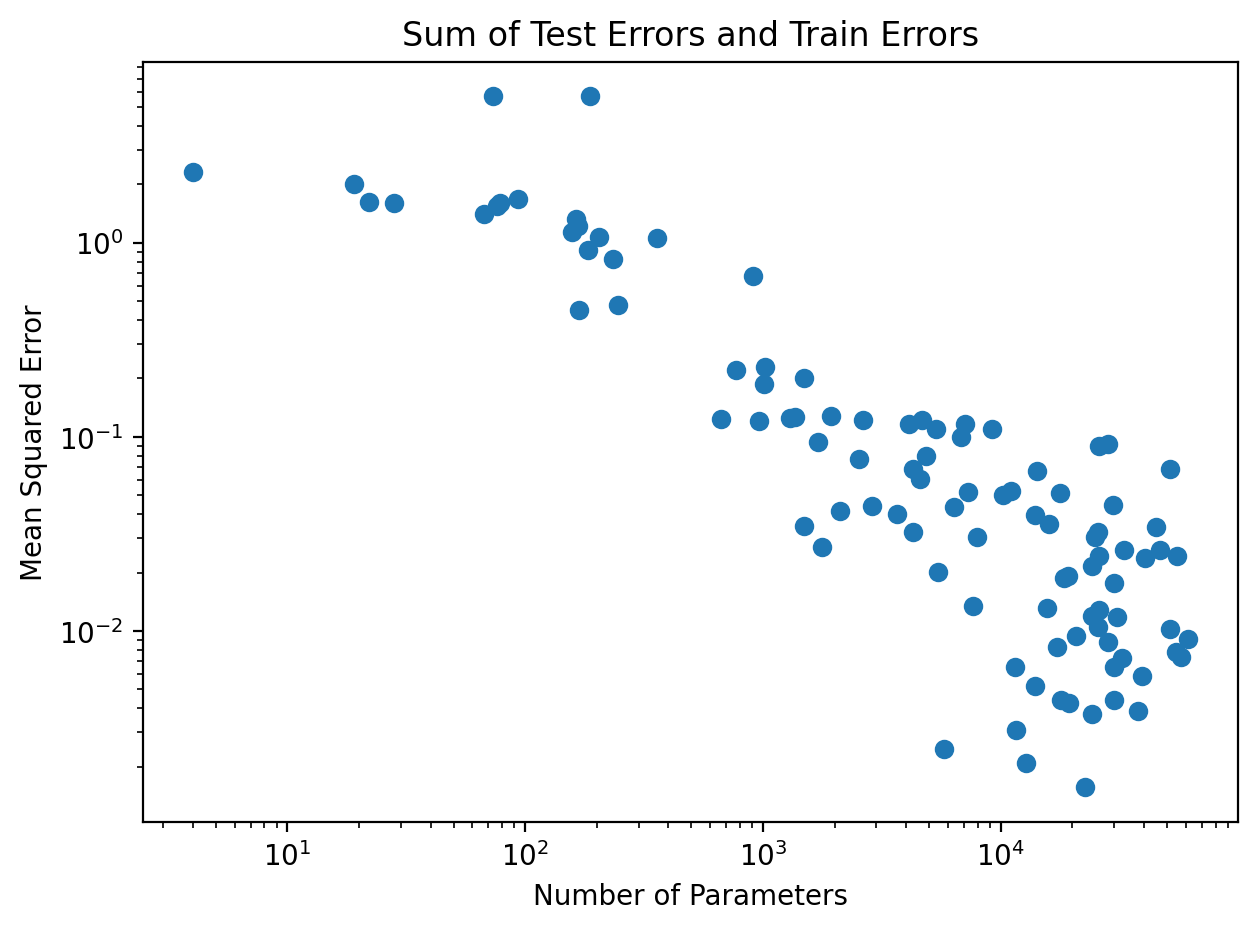

In [15]:
plt.title("Sum of Test Errors and Train Errors")
plt.scatter(number_of_parameters, sum_of_errors)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of Parameters")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.savefig("mse_test_train_sum.png", dpi=600)
plt.show()

In [16]:
best_model = models[36]
nodes = [int(layer.in_features) for layer in best_model._layers[0:-1:2]]
nodes.append(1)

In [17]:
def train_best_model(nodes, nepochs = 1000):
    model = MLP(nodes)
    optimizer = torch.optim.Adam(model.parameters())
    loss = nn.MSELoss()
    losses = np.zeros(nepochs)
    for epoch in range(nepochs):
        losses[epoch] = train(model, train_loader, optimizer, loss)
    return model, losses

In [29]:
best_model, losses = train_best_model(nodes, nepochs=4000)

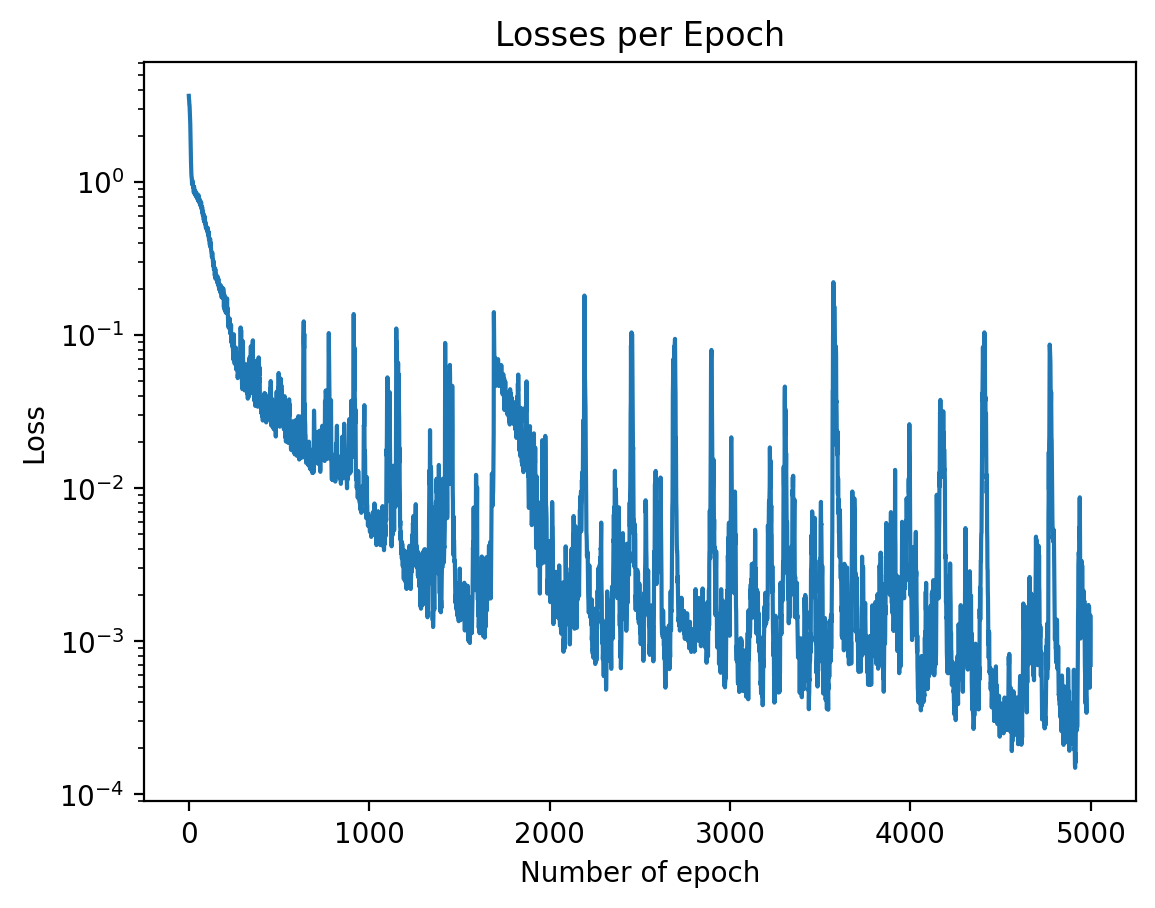

In [24]:
plt.title("Losses per Epoch")
plt.plot(losses)
plt.xlabel("Number of epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.savefig("best_model_losses.png", dpi=600)
plt.show()

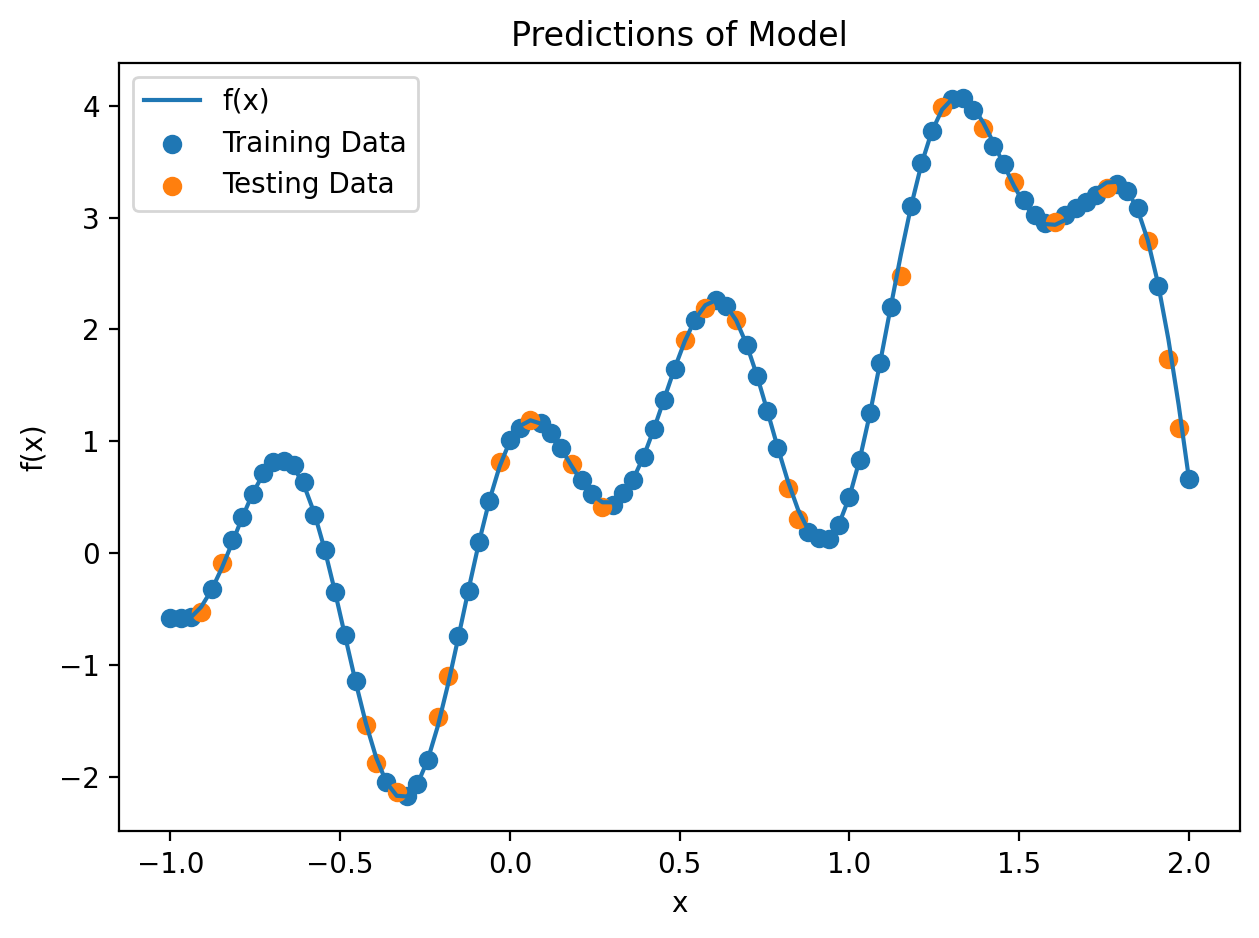

In [32]:
with torch.no_grad():
        train_pred = best_model(train_data.x)
        test_pred = best_model(test_data.x)

plt.title("Predictions of Model")
plt.plot(x, y, label="f(x)")
plt.scatter(train_data.x, train_pred, label="Training Data")
plt.scatter(test_data.x, test_pred, label="Testing Data")
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend()
plt.tight_layout()
plt.savefig("best_model_predictions.png", dpi=600)
plt.show()

In [33]:
with torch.no_grad():
    test_pred = best_model(test_data.x)
    train_pred = best_model(train_data.x)

mse_test = mean_squared_error(test_data.y,test_pred)
mse_train = mean_squared_error(train_data.y,train_pred)

mae_test = mean_absolute_error(test_data.y,test_pred)
mae_train = mean_absolute_error(train_data.y,train_pred)

nodes_network = [int(layer.in_features) for layer in best_model._layers[0:-1:2]]
nodes_network.append(1)

print("Evaluation of Best Model:")
print("Nodes in Network: ", nodes_network)
print('R2 score = %8.5f' % r2_score(test_pred, test_data.y))
print('MSE test  = %8.4f    MAE test  = %8.4f' % (mse_test, mae_test))
print('MSE train = %8.4f    MAE train = %8.4f' % (mse_train,mae_train))

Evaluation of Best Model:
Nodes in Network:  [1, 28, 28, 28, 28, 28, 28, 1]
R2 score =  0.99811
MSE test  =   0.0061    MAE test  =   0.0557
MSE train =   0.0002    MAE train =   0.0108
